In [1]:
import sys
sys.path.insert(0, '..\\..\\frxas.py')

import numpy as np
import h5py
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, minimize, report_fit

from frxas import hdf5_io
from frxas import models
from frxas import visualization

%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
def chi_amp_phase(x, amp, ld, tg, phi, yd, f):
    r"""Summarize the function in one line.

    Function for dimensionless vacancy concentrations assuming ideal behavior
    and overpotential control.

    Parameters
    ----------
    x : list or np.ndarray
        Array or list of arrays of length values.
    ld : float
        :math:`l_{\delta}` : Characteristic length scale of vacancy profile,
        often called the "utilization length".
    tg : float
        :math:`t_G`  : Characteristic time scale of vacancy profile. Reflects
        time scale of switching from kinetic limitations (low frequency) to
        co-limitation by kinetics and diffusion (moderate to high frequency).
    aoo : float
        :math:`A_o` : Thermodynamic factor.
    kappa : float
        Bleh bleah
    f : float
        Applied linear frequency in units of Hz.

    Returns
    -------
    np.ndarray
        Evaluated function for given length array and parameters.
    """
    w = 2 * np.pi * f

    chi = -amp * np.exp(-(x + yd)/ ld * np.sqrt(1 + 1j * tg * w)) * np.exp(- (1j * phi))
   
    return chi

In [18]:
f1 = hdf5_io.get_all_datasets('July18_frXAS', start_indices = [[4, 0, 2, 3], [6, 0, 8, 0], [0, 0, 1]])
# f1 = hdf5_io.get_all_datasets('July18_frXAS', start_indices = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0]])
hdf5_io.close_frxas_file('July18_frXAS')

In [19]:
x, data, frequencies, gases, sizes = hdf5_io.unpack_data(f1, kind='data_adj')

In [5]:
colors = ['k', 'r', 'b', 'c']
markers = [(6, 2, 0), 's', '^', 'o']

colors = colors * (len(colors) % len(data))
markers = markers * (len(colors) % len(data))

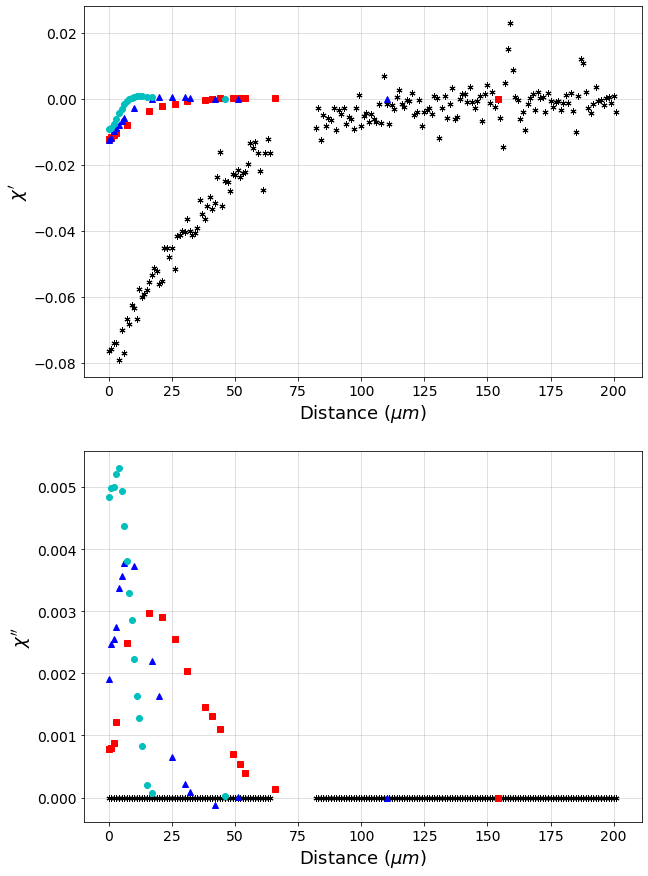

In [6]:
fig, axes = plt.subplots(nrows=2, figsize=(10,15))

for iy in np.arange(0,sizes[0]):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')
# for iy in np.arange(sizes[0],sum(sizes[:2])):
#     visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')
# for iy in np.arange(sum(sizes[:2]),sum(sizes)):
#     visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy], marker=markers[iy], ls='')

plt.show()

In [20]:
fit_params = Parameters()

for iy, y in enumerate(data):
    fit_params.add('amp_%i' % (iy+1), value=np.abs(data[iy][0]), min=0, max=1)
#     fit_params.add('amp_%i' % (iy+1), value=.05, min=0, max=1)
    fit_params.add('ld_%i' % (iy+1), value=15, min=1e-9, max=200)
    fit_params.add('tg_%i' % (iy+1), value=.1, min=1e-9, max=10.0)
    fit_params.add('phi_%i' % (iy+1), value=2, min=0, max=2*np.pi)
    fit_params.add('yd_%i' % (iy+1), value=0, min=0, max=5, vary=False)
    fit_params.add('f_%i' % (iy+1), value=frequencies[iy], vary=False)

# fit_params.add('yd_8', value=1, min=0, max=5, vary=True)
for iy in [1, 5, 9]:
    fit_params.add('phi_%i' % (iy), value=0, min=0, max=2*np.pi, vary=False)

# Setting other parameters within each dataset to be equal
for iy in np.arange(1, sizes[0]):
    fit_params['ld_%i' % (iy+1)].expr = 'ld_1'
    fit_params['tg_%i' % (iy+1)].expr = 'tg_1'

for iy in np.arange(sizes[0]+1, sum(sizes[:2])):
    fit_params['ld_%i' % (iy+1)].expr = 'ld_5'
    fit_params['tg_%i' % (iy+1)].expr = 'tg_5'

for iy in np.arange(sum(sizes[:2])+1, len(data)):
    fit_params['ld_%i' % (iy+1)].expr = 'ld_9'
    fit_params['tg_%i' % (iy+1)].expr = 'tg_9'

In [21]:
mini=lmfit.Minimizer(models.objective_fun, fit_params, fcn_args=(x, data, chi_amp_phase))

In [22]:
out = mini.minimize(method='least_squares')
# out = mini.minimize(method='least_squares', params=out.params)
print(out.redchi)
report_fit(out.params)

5.029444639374965e-06
[[Variables]]
    amp_1:   0.08371488 +/- 7.1864e-04 (0.86%) (init = 0.07647562)
    ld_1:    38.3813570 +/- 0.50537778 (1.32%) (init = 15)
    tg_1:    3.29014138 +/- 0.66644523 (20.26%) (init = 0.1)
    phi_1:   0 (fixed)
    yd_1:    0 (fixed)
    f_1:     0 (fixed)
    amp_2:   0.01167455 +/- 0.00106415 (9.12%) (init = 0.01223474)
    ld_2:    38.3813570 +/- 0.50537778 (1.32%) == 'ld_1'
    tg_2:    3.29014138 +/- 0.66644523 (20.26%) == 'tg_1'
    phi_2:   0.03369593 +/- 0.09208560 (273.28%) (init = 2)
    yd_2:    0 (fixed)
    f_2:     0.25 (fixed)
    amp_3:   0.01215481 +/- 0.00107548 (8.85%) (init = 0.01263023)
    ld_3:    38.3813570 +/- 0.50537778 (1.32%) == 'ld_1'
    tg_3:    3.29014138 +/- 0.66644523 (20.26%) == 'tg_1'
    phi_3:   0.10766585 +/- 0.08883848 (82.51%) (init = 2)
    yd_3:    0 (fixed)
    f_3:     1 (fixed)
    amp_4:   0.01190152 +/- 0.00129510 (10.88%) (init = 0.01031826)
    ld_4:    38.3813570 +/- 0.50537778 (1.32%) == 'ld_1'
    t

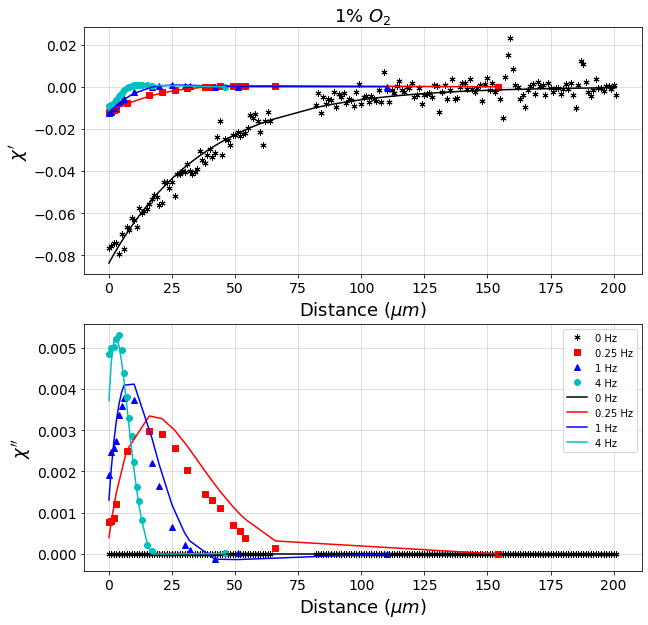

In [23]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(0,sizes[0]):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label=str(frequencies[iy]) + ' Hz')
for iy in np.arange(0,sizes[0]):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_amp_phase),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz')
    
axes[0].set_title('1% $O_2$', fontsize=18)
plt.legend()
plt.show()
# plt.savefig(r'Plots\Pattern_Model_Amp_yd_1%O2.png', dpi=300, bbox_inches='tight')

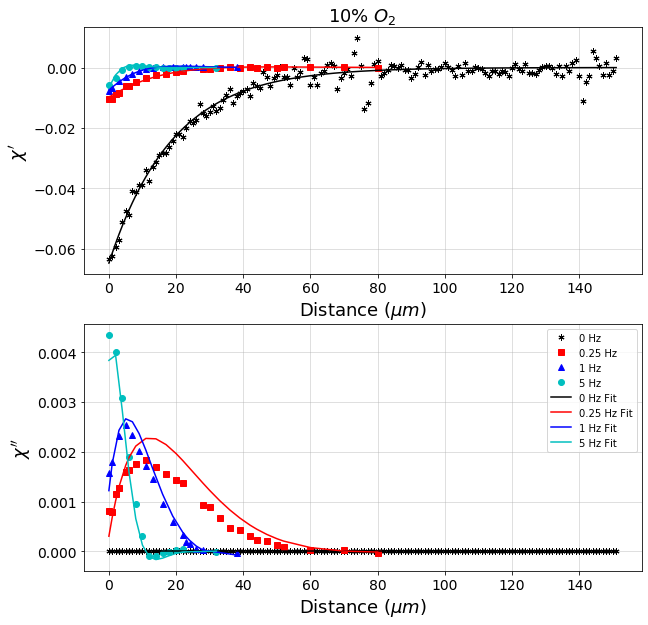

In [24]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(sizes[0],sum(sizes[:2])):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='',
                           label=str(frequencies[iy]) + ' Hz')

for iy in np.arange(sizes[0],sum(sizes[:2])):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_amp_phase),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('10% $O_2$', fontsize=18)
plt.legend()
plt.show()

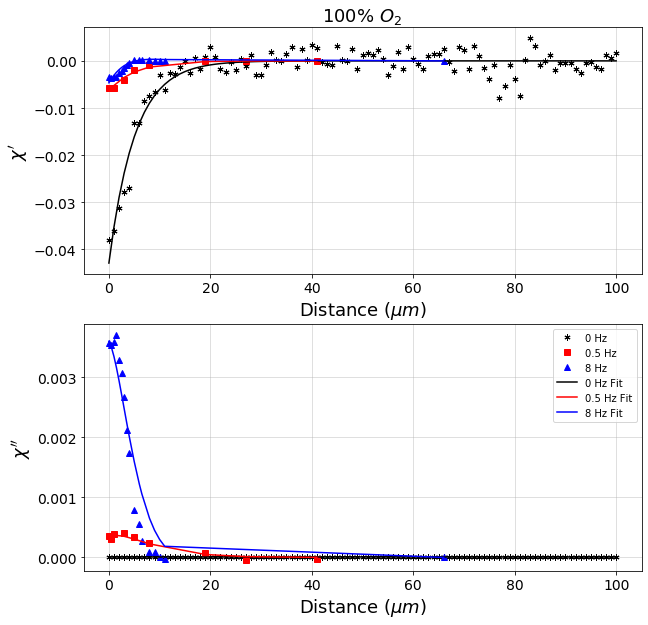

In [25]:
fig, axes = plt.subplots(nrows=2, figsize=(10,10))

for iy in np.arange(sum(sizes[:2]),sum(sizes)):
    visualization.plot_chi(axes, x[iy], data[iy], color=colors[iy],
                           marker=markers[iy], ls='', 
                           label=str(frequencies[iy]) + ' Hz')
for iy in np.arange(sum(sizes[:2]),sum(sizes)):
    visualization.plot_chi(axes, x[iy], models.dataset_fun(out.params, iy, x[iy], chi_amp_phase),
                           color=colors[iy], marker='',
                           label=str(frequencies[iy]) + ' Hz Fit')
    
axes[0].set_title('100% $O_2$', fontsize=18)
plt.legend()
plt.show()